In [1]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/Users/eharkin/Documents/projects/5HTGIF


In [2]:
import pickle
import warnings
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from grr.pltools import hide_border

In [3]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
plt.rc('text', usetex = False)
IMG_PATH = os.path.join('figs', 'ims', 'GIF_individuals')
MOD_PATH = os.path.join('data', 'models')

# Metadata

In [4]:
metadata = {}

for celltype in ['5HT', 'GABA', 'mPFC']:
    try:
        metadata[celltype] = pd.read_csv(os.path.join(MOD_PATH, celltype, '{}_goodcellsmetadata.csv'.format(celltype)))
        minified_metadata = pd.read_csv(
            os.path.join(MOD_PATH, celltype, '{}_minified_goodcellsmetadata.csv'.format(celltype))
        )
        metadata[celltype]['minified'] = False
        minified_metadata['minified'] = True
        metadata[celltype] = metadata[celltype].append(minified_metadata, ignore_index=True)
    except IOError:
        warnings.warn('IOError trying to collect {} benchmark metadata. Skipping.'.format(celltype))

In [5]:
metadata['GABA']

,dataset,nbOfSpikes,nbOfSpikesInROI,nbOfTraces,nbOfTracesInROI,traceDuration,traceDurationInROI,dataset.1,nbOfSpikes.1,nbOfSpikesInROI.1,nbOfTraces.1,nbOfTracesInROI.1,traceDuration.1,traceDurationInROI.1,Cell,minified
0,training,1147,1147.0,3,3,60000.0,59000.0,test,571,525.0,9,9,10000.0,9000.0,DRN351,False
1,training,1659,1659.0,3,3,60000.0,59000.0,test,857,798.0,9,9,10000.0,9000.0,DRN354,False
2,training,1355,1355.0,3,3,60000.0,59000.0,test,690,620.0,9,9,10000.0,9000.0,DRN355,False
3,training,794,794.0,3,3,60000.0,59000.0,test,347,311.0,9,9,10000.0,9000.0,DRN356,False
4,training,1075,1075.0,3,3,60000.0,59000.0,test,554,500.0,9,9,10000.0,9000.0,DRN357,False
5,training,699,699.0,3,3,60000.0,59000.0,test,387,350.0,9,9,10000.0,9000.0,SOM_6_LW,False
6,training,803,803.0,3,3,60000.0,59000.0,test,390,347.0,9,9,10000.0,9000.0,SOM_9_LW,False
7,training,708,708.0,3,3,60000.0,59000.0,test,353,326.0,9,9,10000.0,9000.0,SOM_14_LW,False
8,training,1277,1277.0,3,3,60000.0,59000.0,test,624,570.0,9,9,10000.0,9000.0,DRN415,False
9,training,278,278.0,3,3,60000.0,59000.0,test,128,118.0,9,9,10000.0,9000.0,DRN416,False


Text(0.5,0,'No. spikes')

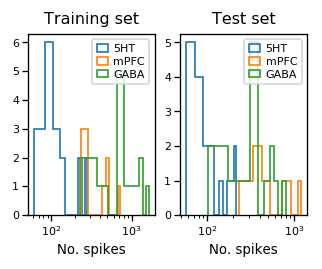

In [6]:
train_ax = plt.subplot(121)
train_ax.set_title('Training set')
for celltype in metadata:
    if 'minified' not in celltype:
        train_ax.hist(metadata[celltype].loc[~metadata[celltype]['minified'], 'nbOfSpikesInROI'], label=celltype, histtype='step')
train_ax.legend()
train_ax.set_xscale('log')
train_ax.set_xlabel('No. spikes')

test_ax = plt.subplot(122)
test_ax.set_title('Test set')
for celltype in metadata:
    if 'minified' not in celltype:
        test_ax.hist(metadata[celltype].loc[~metadata[celltype]['minified'], 'nbOfSpikesInROI.1'], label=celltype, histtype='step')
test_ax.legend()
test_ax.set_xscale('log')
test_ax.set_xlabel('No. spikes')

Text(0.5,0,'No. spikes')

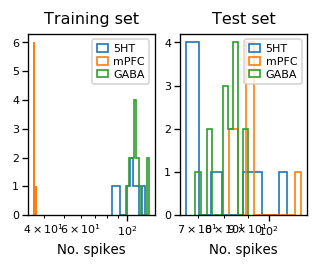

In [7]:
train_ax = plt.subplot(121)
train_ax.set_title('Training set')
for celltype in metadata:
    if 'minified' not in celltype:
        train_ax.hist(metadata[celltype].loc[metadata[celltype]['minified'], 'nbOfSpikesInROI'], label=celltype, histtype='step')
train_ax.legend()
train_ax.set_xscale('log')
train_ax.set_xlabel('No. spikes')

test_ax = plt.subplot(122)
test_ax.set_title('Test set')
for celltype in metadata:
    if 'minified' not in celltype:
        test_ax.hist(metadata[celltype].loc[metadata[celltype]['minified'], 'nbOfSpikesInROI.1'], label=celltype, histtype='step')
test_ax.legend()
test_ax.set_xscale('log')
test_ax.set_xlabel('No. spikes')

# Benchmarks

In [8]:
def strip_string_from_col_names(dframe, string):
    newdframe = dframe.rename(columns=lambda x: re.sub(string, '', x))
    return newdframe

In [9]:
benchmarks = {}

for celltype in ['5HT', 'GABA', 'mPFC']:
    try:
        benchmarks[celltype] = {}
        for benchtype in ['Md_8', 'R2_V', 'R2_dV']:
            benchmarks[celltype][benchtype] = pd.read_csv(
                os.path.join(MOD_PATH, celltype, '{}_goodcellsbenchmark_{}.csv'.format(celltype, benchtype))
            )
            minified_bench = pd.read_csv(
                os.path.join(MOD_PATH, celltype, '{}_minified_goodcellsbenchmark_{}.csv'.format(celltype, benchtype))
            )
            benchmarks[celltype][benchtype]['minified'] = False
            minified_bench = strip_string_from_col_names(minified_bench, '_minified')
            minified_bench['minified'] = True
            benchmarks[celltype][benchtype] = benchmarks[celltype][benchtype].append(minified_bench, ignore_index=True)
    except IOError:
        warnings.warn('IOError trying to collect {} benchmarks. Skipping.'.format(celltype))

del minified_bench

## Print Md* benchmarks

In [10]:
benchmarks['mPFC']['Md_8']

,Cell,mPFC_AugmentedGIFs,mPFC_GIFs,mPFC_iGIF_NPs,mPFC_iGIF_VRs,minified
0,APFC4,0.459361,0.495369,0.559590,0.584896,False
1,APFC5,0.941472,0.905379,0.946556,0.941714,False
2,APFC6,0.873481,0.896424,0.968248,0.968369,False
3,APFC7,0.831116,0.818203,0.870098,0.880005,False
4,APFC8,0.686774,0.736715,0.787159,0.760927,False
5,APFC9,0.561205,0.766935,0.867624,0.891481,False
6,APFC6,0.851018,0.847421,0.813413,0.835273,False
7,APFC4,0.494480,0.639891,0.582775,0.557636,True
8,APFC5,0.962333,0.930447,NaN,NaN,True
9,APFC6,0.921958,0.935547,0.940177,0.932593,True


In [11]:
benchmarks['5HT']['Md_8']

,5HT_AugmentedGIFs,5HT_GIFs,5HT_iGIF_NPs,Cell,minified
0,0.260279,0.190442,0.351399,DRN307,False
1,0.541984,0.445961,0.651414,DRN308,False
2,0.704925,0.434109,0.630207,DRN317,False
3,0.338619,0.181666,0.394415,DRN318,False
4,0.349153,0.388006,0.566951,DRN319,False
5,0.505238,0.404280,0.744791,DRN320,False
6,0.456956,0.350482,0.444410,DRN321,False
7,0.668628,0.647018,0.811447,DRN324,False
8,0.371117,0.241436,0.763838,DRN325,False
9,0.617076,0.430276,0.541263,DRN327,False


In [12]:
benchmarks['GABA']['Md_8']

,Cell,GABA_AugmentedGIFs,GABA_GIFs,GABA_iGIF_NPs,GABA_iGIF_VRs,minified
0,DRN351,0.578773,0.433792,0.857827,0.839378,False
1,DRN354,0.910052,0.892943,0.932474,0.931691,False
2,DRN355,0.820886,0.739808,0.925310,0.917081,False
3,DRN356,0.958465,0.928020,0.971956,0.972217,False
4,DRN357,0.846999,0.855316,0.902204,0.903580,False
5,SOM_6_LW,0.849512,0.855059,0.931062,0.810295,False
6,SOM_9_LW,0.916489,0.916146,0.927652,0.926949,False
7,SOM_14_LW,0.849205,0.845881,0.883989,0.883353,False
8,DRN415,0.922663,0.927481,0.960152,0.958090,False
9,DRN416,0.877758,0.880826,0.908644,0.905389,False


In [13]:
benchmarks['GABA']

{'Md_8':          Cell  GABA_AugmentedGIFs  GABA_GIFs  GABA_iGIF_NPs  GABA_iGIF_VRs  \
 0      DRN351            0.578773   0.433792       0.857827       0.839378   
 1      DRN354            0.910052   0.892943       0.932474       0.931691   
 2      DRN355            0.820886   0.739808       0.925310       0.917081   
 3      DRN356            0.958465   0.928020       0.971956       0.972217   
 4      DRN357            0.846999   0.855316       0.902204       0.903580   
 5    SOM_6_LW            0.849512   0.855059       0.931062       0.810295   
 6    SOM_9_LW            0.916489   0.916146       0.927652       0.926949   
 7   SOM_14_LW            0.849205   0.845881       0.883989       0.883353   
 8      DRN415            0.922663   0.927481       0.960152       0.958090   
 9      DRN416            0.877758   0.880826       0.908644       0.905389   
 10     DRN419            0.759458   0.806426       0.827719       0.892579   
 11     DRN421            0.604945   0.53963

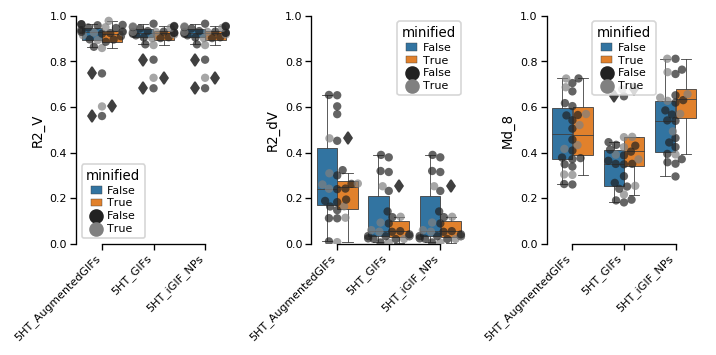

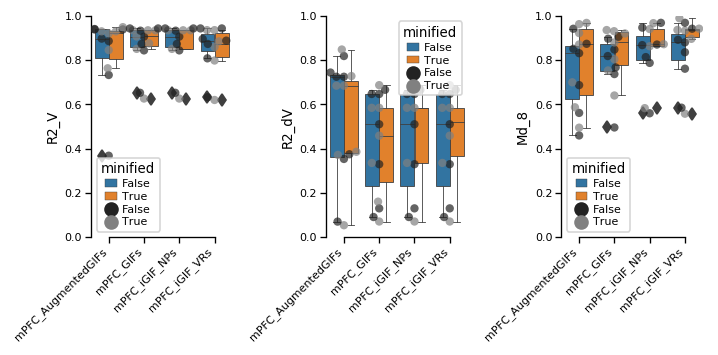

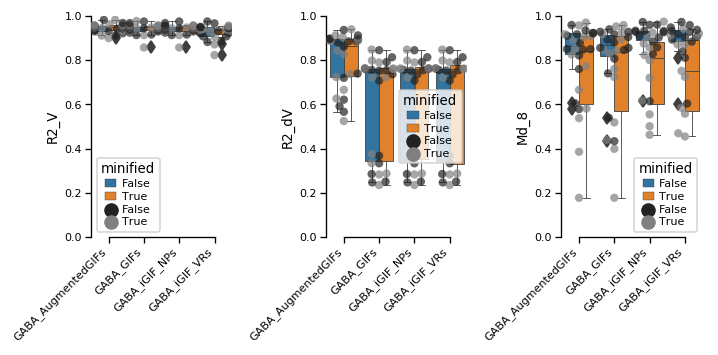

In [14]:
for celltype in benchmarks:
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes = axes.flatten().tolist()
    
    for i, benchtype in enumerate(benchmarks[celltype]):
        axes[i].set_ylim(0, 1)
        chart = sns.boxplot(
            x='variable', y='value', hue='minified', 
            data=benchmarks[celltype][benchtype].melt(id_vars=['Cell', 'minified']), 
            ax=axes[i]
        )
        sns.swarmplot(
            x='variable', y='value', hue='minified',
            data=benchmarks[celltype][benchtype].melt(id_vars=['Cell', 'minified']), 
            ax=axes[i], color='gray', alpha=0.7
        )
        axes[i].set_xticklabels(chart.get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(benchtype)
        axes[i].set_xlabel('')
    
    sns.despine(trim=True)
    plt.tight_layout()

## Selected benchmarks

Most important benchmarks for presentations, etc.

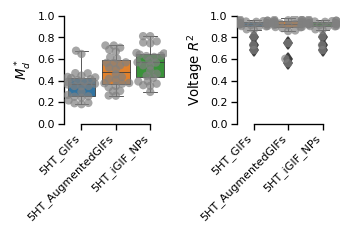

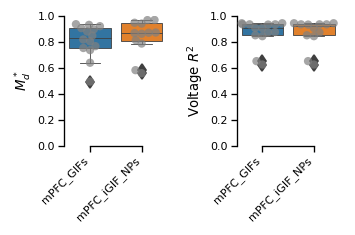

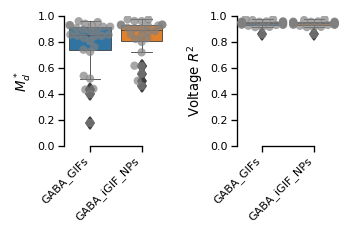

In [15]:
selected_mods = {
    '5HT': ['5HT_GIFs', '5HT_AugmentedGIFs', '5HT_iGIF_NPs'],
    'GABA': ['GABA_GIFs', 'GABA_iGIF_NPs'],
    'mPFC': ['mPFC_GIFs', 'mPFC_iGIF_NPs']
}
for celltype in benchmarks:
    fig, axes = plt.subplots(1, 2, figsize=(3, 2))
    axes = axes.flatten().tolist()
    
    for i, benchtype in enumerate(['Md_8', 'R2_V']):
        cols = ['Cell']
        cols.extend(selected_mods[celltype])
        data_filtered = benchmarks[celltype][benchtype].loc[:, cols]
        
        axes[i].set_ylim(0, 1)
        chart = sns.boxplot(
            x='variable', y='value', data=data_filtered.melt(id_vars=['Cell']), 
            ax=axes[i]
        )
        sns.swarmplot(
            x='variable', y='value', data=data_filtered.melt(id_vars=['Cell']), 
            ax=axes[i], color='gray', alpha=0.7
        )
        axes[i].set_xticklabels(chart.get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(benchtype)
        axes[i].set_xlabel('')
    
    axes[0].set_ylabel('$M_d^*$')
    axes[1].set_ylabel('Voltage $R^2$')
    
    sns.despine(trim=True)
    plt.tight_layout()
    
    if IMG_PATH is not None:
        plt.savefig(os.path.join(IMG_PATH, '{}_selected_benchmarks.png'.format(celltype)))

# Sample traces

In [16]:
sample_traces = {}
for celltype in ['GABA', '5HT', 'mPFC']:
    try:
        with open(
            os.path.join(
                MOD_PATH, celltype, '{}_goodcellsbenchmark_sample_traces.pkl'.format(celltype)
            ), 'rb'
        ) as f:
            sample_traces[celltype] = pd.DataFrame(pickle.load(f))
            f.close()
    except IOError:
        warnings.warn('Could not load sample traces for {}, skipping.'.format(celltype))

In [17]:
sample_traces['5HT'].head()

,5HT_AugmentedGIFs,5HT_GIFs,5HT_iGIF_NPs,Cell,Data,Input,Time
0,"{u'V': [-62.44283073713969, -62.44414327681962...","{u'V': [-62.44283073713969, -62.44463616450748...","{u'V': [-62.44283073713969, -62.44463616450748...",DRN307,"{u'V': [-62.44283073713969, -62.44170067880986...","[0.00042724612285383046, 0.00048828125, 0.0001...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
1,"{u'V': [-66.37700211467825, -66.3762495379932,...","{u'V': [-66.37700211467825, -66.37736189698705...","{u'V': [-66.37700211467825, -66.37736189698705...",DRN308,"{u'V': [-66.37700211467825, -66.25991119216224...","[0.01837158203125, 0.01849365234375, 0.0180664...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
2,"{u'V': [-54.20767474868103, -54.20945757773938...","{u'V': [-54.20767474868103, -54.21086811595364...","{u'V': [-54.20767474868103, -54.21086811595364...",DRN317,"{u'V': [-54.20767474868103, -54.34390574053214...","[0.02050781436264515, 0.02020263858139515, 0.0...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
3,"{u'V': [-50.29780490431342, -50.29981981651265...","{u'V': [-50.29780490431342, -50.30470428397287...","{u'V': [-50.29780490431342, -50.30470428397287...",DRN318,"{u'V': [-50.29780490431342, -50.29378849362245...","[0.015441895462572575, 0.015441895462572575, 0...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."
4,"{u'V': [-55.92658907013903, -55.93179688115562...","{u'V': [-55.92658907013903, -55.93714224013458...","{u'V': [-55.92658907013903, -55.93714224013458...",DRN319,"{u'V': [-55.92658907013903, -56.09155246668678...","[-0.014465332962572575, -0.014831543900072575,...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,..."


In [18]:
def sample_trace_plot(trace_df, xlims, model_type, model_label, model_color, fname=None):
    
    sample_tr_spec = gs.GridSpec(4, 1, height_ratios=[0.2, 1, 0.3, 0.3])
    
    plt.figure(figsize=(3, 2))
    
    plt.subplot(sample_tr_spec[0, :])
    plt.plot(
        trace_df.loc[i, 'Time'], 
        trace_df.loc[i, 'Input'], 
        color='gray'
    )
    plt.ylabel('I (nA)')
    plt.xticks([])
    plt.xlim(xlims)
    sns.despine(trim=True, ax=plt.gca(), bottom=True)
    
    plt.subplot(sample_tr_spec[1, :])
    plt.plot(
        trace_df.loc[i, 'Time'], 
        trace_df.loc[i, 'Data']['V'], 
        color='black', label='Real neuron'
    )
    plt.plot(
        trace_df.loc[i, 'Time'], 
        trace_df.loc[i, model_type]['V'], 
        color=model_color, alpha=0.7, label=model_label
    )
    plt.xticks([])
    plt.xlim(xlims)
    sns.despine(trim=True, ax=plt.gca(), bottom=True)
    plt.ylabel('V (mV)')
    plt.legend()
    
    plt.subplot(sample_tr_spec[2, :])
    plt.eventplot(trace_df.loc[i, 'Data']['spks'], color='black')
    plt.xticks([])
    plt.xlim(xlims)
    sns.despine(trim=True, ax=plt.gca(), bottom=True)
    
    plt.subplot(sample_tr_spec[3, :])
    plt.eventplot(trace_df.loc[i, model_type]['spks'], color=model_color)
    plt.xlim(xlims)
    sns.despine(trim=True, ax=plt.gca())
    plt.xlabel('Time (ms)')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    
    if IMG_PATH is not None and fname is not None:
        plt.savefig(os.path.join(IMG_PATH, fname))
        
    plt.show()

## mPFC sample traces

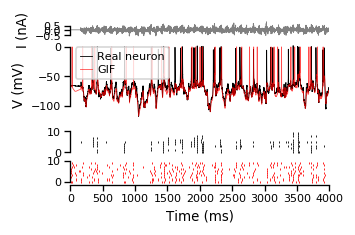

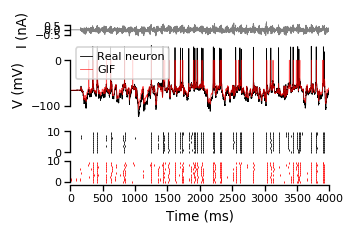

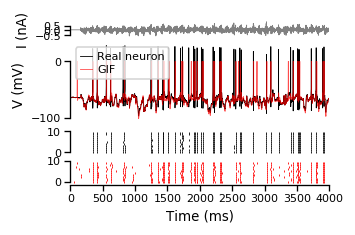

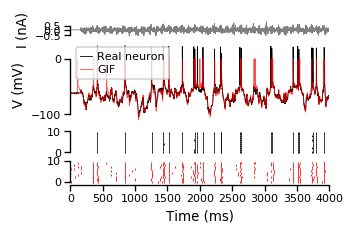

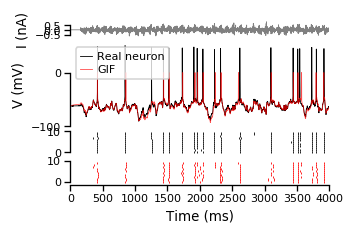

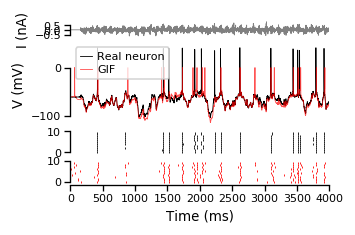

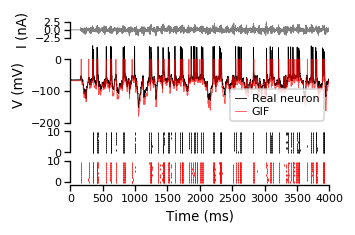

In [19]:
for i in range(sample_traces['mPFC'].shape[0]):
    sample_trace_plot(
        sample_traces['mPFC'], (0, 4000), 'mPFC_GIFs', 'GIF', 'r', 
        '{}_sample_trace_{}.png'.format('mPFC_GIFs', i)
    )

## GABA sample traces

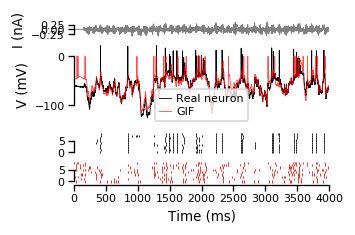

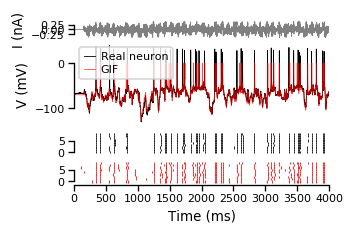

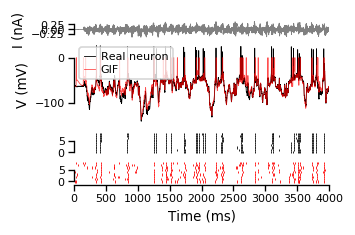

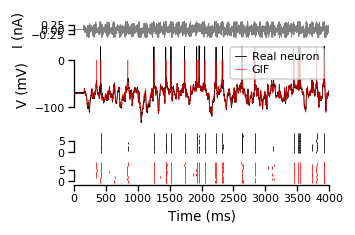

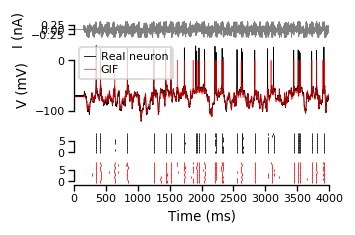

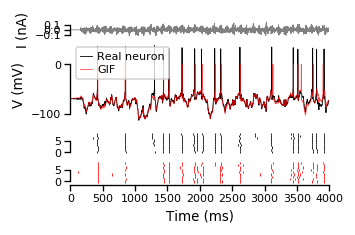

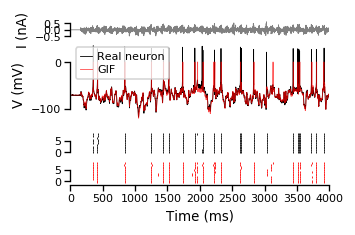

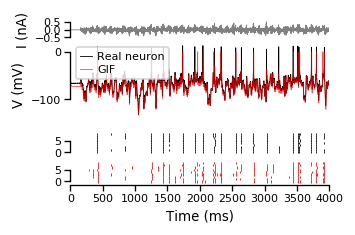

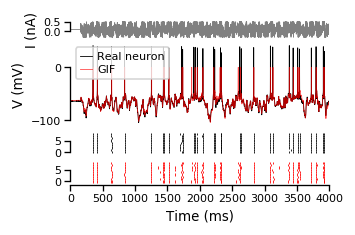

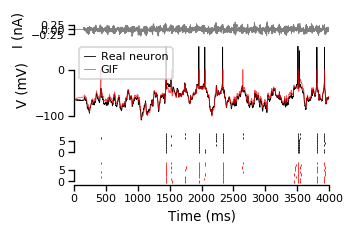

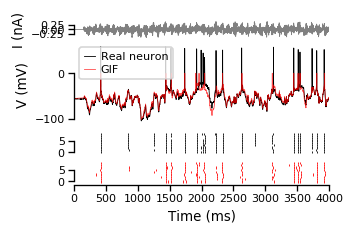

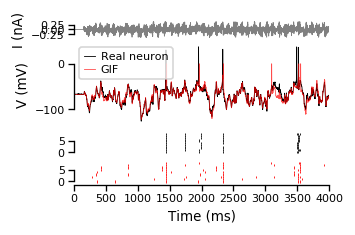

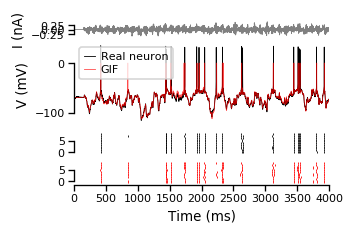

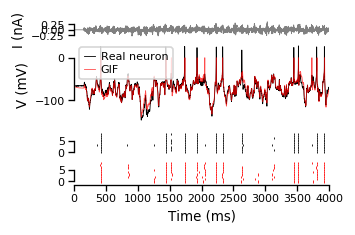

In [20]:
for i in range(sample_traces['GABA'].shape[0]):
    sample_trace_plot(
        sample_traces['GABA'], (0, 4000), 'GABA_GIFs', 'GIF', 'r', 
        '{}_sample_trace_{}.png'.format('GABA_GIFs', i)
    )

## 5HT sample traces

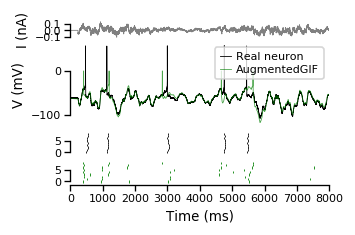

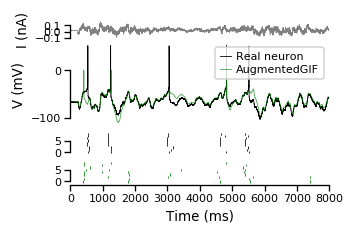

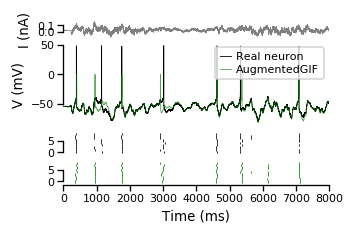

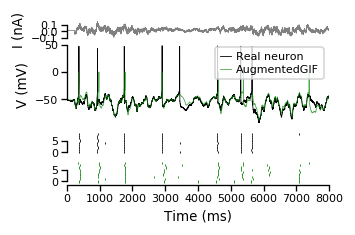

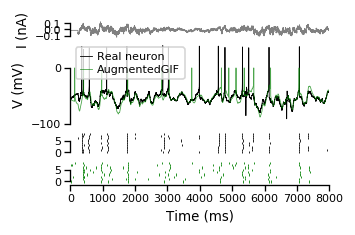

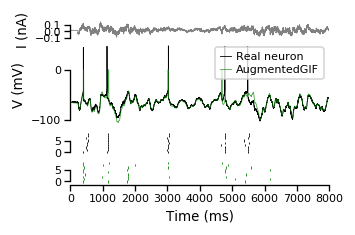

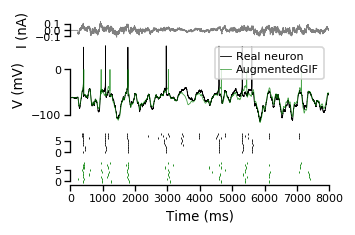

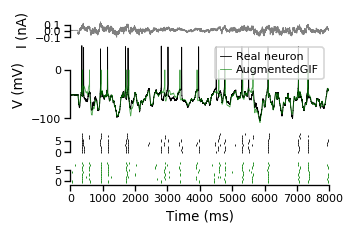

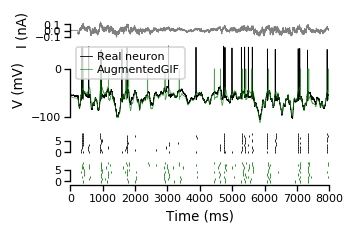

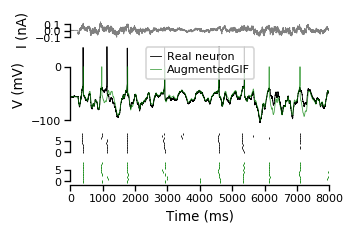

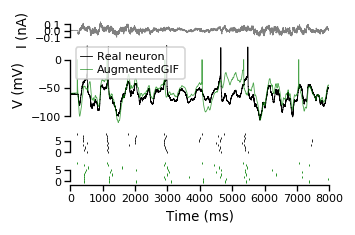

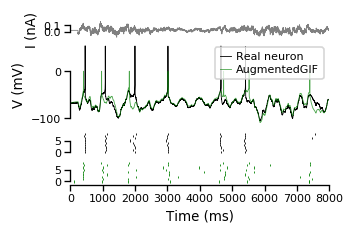

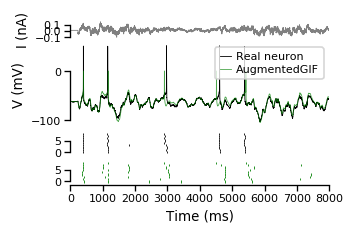

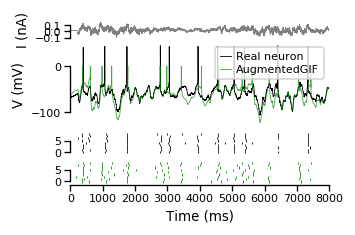

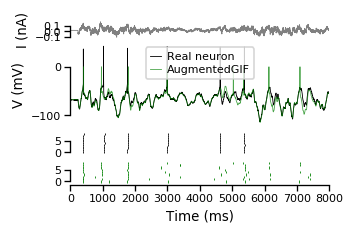

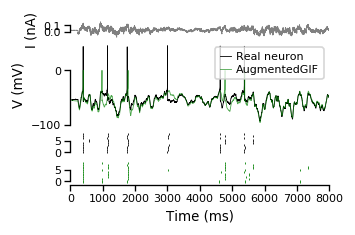

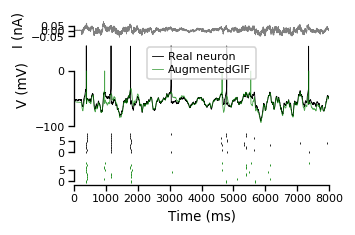

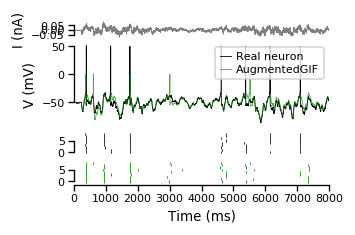

In [21]:
for i in range(sample_traces['5HT'].shape[0]):
    sample_trace_plot(
        sample_traces['5HT'], (0, 8000), '5HT_AugmentedGIFs', 'AugmentedGIF', 'g',
        '{}_sample_trace_{}.png'.format('5HT_AugmentedGIFs', i)
    )